In [2]:
from weavepy import *

use_aliases = True

In [3]:
# Parameters
## Climate
climate_variable = "2m_temperature"
climate_variable_comparison = '<=' # '<', '<=', '>', or '>='
climate_variable_threshold = 5 # Number in units of variable
## Energy 
energy_variable = "solar_generation_capacity_factor"
energy_variable_comparison = '<' # '<', '<=', '>', or '>='
energy_variable_threshold = 0.05 # Number in units of variable
##Geography
country = "FR"

In [4]:
data = load_vars([climate_variable, energy_variable], future_models = ["cmcc_cm2_sr5", "mpi_esm1_2_hr", "ec_earth3"])
data

  0%|                                                     | 0/2 [00:00<?, ?it/s]

2m_temperature


/Users/bourdin/Softs/miniforge3/envs/weave/lib/python3.13/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension model because variable model is not a coordinate. To create an index for model, please first call `.set_coords('model')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.34s/it]

solar_generation_capacity_factor


/Users/bourdin/Softs/miniforge3/envs/weave/lib/python3.13/site-packages/xarray/structure/concat.py:540: UserWarning: No index created for dimension model because variable model is not a coordinate. To create an index for model, please first call `.set_coords('model')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
100%|█████████████████████████████████████████████| 2/2 [00:15<00:00,  7.72s/it]


<xarray.Dataset> Size: 54MB
Dimensions:                           (model: 4, Date: 753888)
Coordinates:
  * model                             (model) <U13 208B 'ERA5' ... 'ec_earth3'
  * Date                              (Date) datetime64[ns] 6MB 1980-01-01 .....
Data variables:
    2m_temperature                    (model, Date) float64 24MB 0.5372 ... 1...
    solar_generation_capacity_factor  (model, Date) float64 24MB 0.0 0.0 ... 0.0

In [5]:
# Aggregate
data_daily = data.groupby("Date.date").mean()

In [6]:
# Identify problematic days
climate_days = identify_pb_days(data_daily[climate_variable], climate_variable_comparison, climate_variable_threshold).rename("climate_event")
energy_days = identify_pb_days(data_daily[energy_variable], energy_variable_comparison, energy_variable_threshold).rename("energy_event")
compound_days = (climate_days & energy_days).rename("compound_event")

In [29]:
# Identify events
climate_events, energy_events, compound_events = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for a in data.model.values:
    climate_events = pd.concat([climate_events, identify_events(climate_days.sel(model = a), model = a, country = country)])
    energy_events = pd.concat([energy_events, identify_events(energy_days.sel(model = a), model = a, country = country)])
    compound_events = pd.concat([compound_events, identify_events(compound_days.sel(model = a), model = a, country = country)])

In [30]:
climate_events

,model,scenario,country,eventID,start,end,duration,year
0,ERA5,,FR,0,1980-01-01,1980-01-23,23 days,1980
0,ERA5,,FR,1,1980-01-25,1980-01-29,5 days,1980
0,ERA5,,FR,2,1980-02-11,1980-02-13,3 days,1980
0,ERA5,,FR,3,1980-02-27,1980-03-05,8 days,1980
0,ERA5,,FR,4,1980-03-13,1980-03-17,5 days,1980
...,...,...,...,...,...,...,...,...
0,ec_earth3,,FR,448,2065-11-20,2065-11-21,2 days,2065
0,ec_earth3,,FR,449,2065-11-23,2065-12-01,9 days,2065
0,ec_earth3,,FR,450,2065-12-05,2065-12-07,3 days,2065
0,ec_earth3,,FR,451,2065-12-16,2065-12-23,8 days,2065


In [28]:
def identify_events(series, model = "", scenario = "", country = ""):
    events = pd.DataFrame()
    columns = ["model", "scenario", "country", "eventID", "start", "end", "duration"]
    event_ongoing = False
    eventID = 0
    for d in series.date.values:
        pb = (series.sel(date = d) == True)
        d = pd.to_datetime(d)
        if pb:
            if not event_ongoing: # New event
                event_ongoing = True
                start = d
                end = d
            elif event_ongoing: # Event in continuing
                end = d
        else:
            if event_ongoing:
                event_ongoing = False
                event = pd.DataFrame([[model, scenario, country, eventID, start, end, d-start]], columns = columns)
                events = pd.concat([events, event])
                eventID += 1
    return events.assign(year = events.start.dt.year)

In [11]:
# period length
period_len = {a: get_period_length(a, data) for a in data.model.values}
period_min_max = {a: get_period_min_max(a, data) for a in data.model.values}

In [36]:
# Compute number of events per year
N_climate_events = climate_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_energy_events = energy_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()
N_compound_events = compound_events.groupby(["model", "scenario", "country", "year"]).eventID.nunique().reset_index()

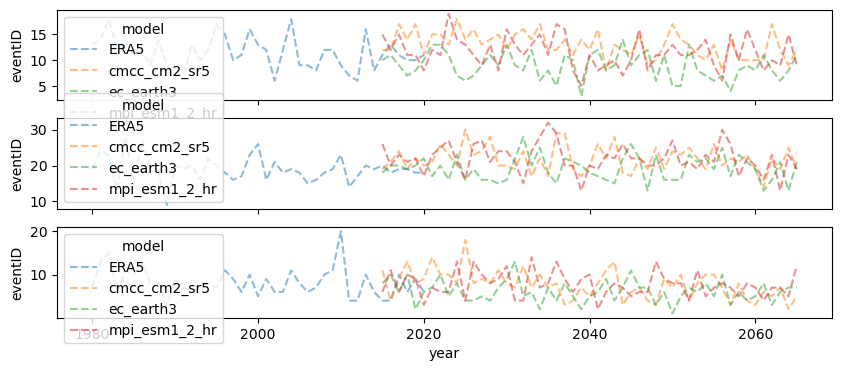

In [46]:
fig, axs = plt.subplots(3, figsize = [10, 4], sharex = True) # TODO: Rolling mean
for i, N in enumerate([N_climate_events, N_energy_events, N_compound_events]):
    sns.lineplot(data = N, x = "year", y = "eventID", hue = "model", linestyle = '--', ax = axs[i], alpha = 0.5)

In [ ]:
fig, axs = plt.subplots(1, 3, sharey = True)
nb_events_barplot(climate_events, period_len, axs[0], palette)
axs[0].set_title("Climate events")
nb_events_barplot(energy_events, period_len, axs[1], palette)
axs[1].set_title("Energy events")
nb_events_barplot(compound_events, period_len, axs[2], palette)
axs[2].set_title("Compound events")

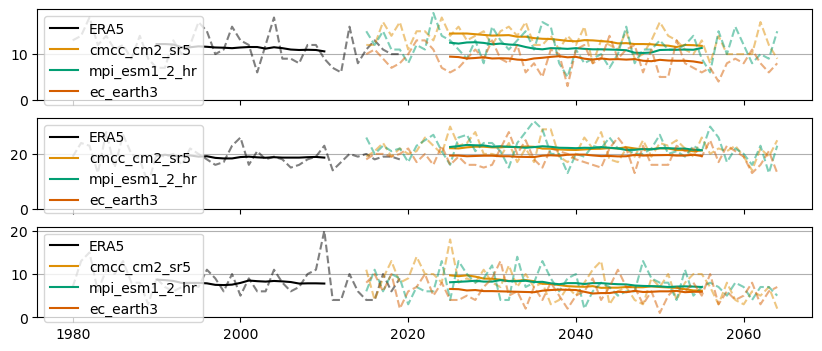

In [86]:
fig, axs = plt.subplots(3, figsize = [10, 4], sharex = True)
for i, d in enumerate([climate_events, energy_events, compound_events]):
    for j, a in enumerate(climate_events):
        N_events_per_year = pd.Series([e[0].year for e in d[a]]).value_counts().sort_index()
        N_events_per_year = pd.DataFrame(index = np.arange(*period_min_max[a])).join(N_events_per_year).fillna(0)
        N_events_per_year.plot(ax = axs[i], color = palette[a], linestyle = '--', alpha = 0.5, legend = False)
        N_events_per_year.rolling(20, center = True).mean().rename(columns={"count":a}).plot(ax = axs[i], color = palette[a], label = a)# legend = False,)
    axs[i].grid(axis = "y")
    axs[i].set_ylim(0)

Text(0.5, 1.0, 'Compound events')

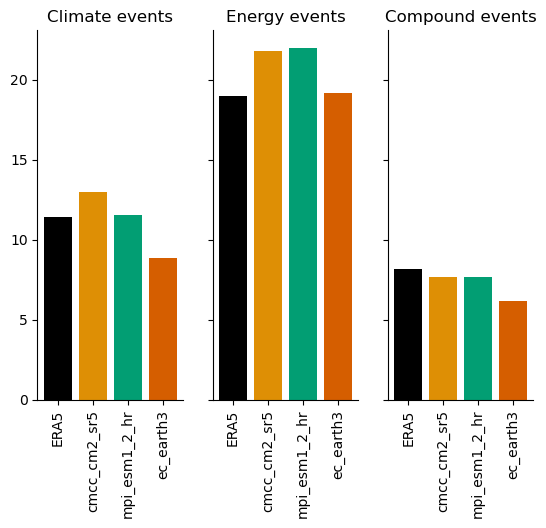

In [87]:
fig, axs = plt.subplots(1, 3, sharey = True)
nb_events_barplot(climate_events, period_len, axs[0], palette)
axs[0].set_title("Climate events")
nb_events_barplot(energy_events, period_len, axs[1], palette)
axs[1].set_title("Energy events")
nb_events_barplot(compound_events, period_len, axs[2], palette)
axs[2].set_title("Compound events")

(0.0, 15.0)

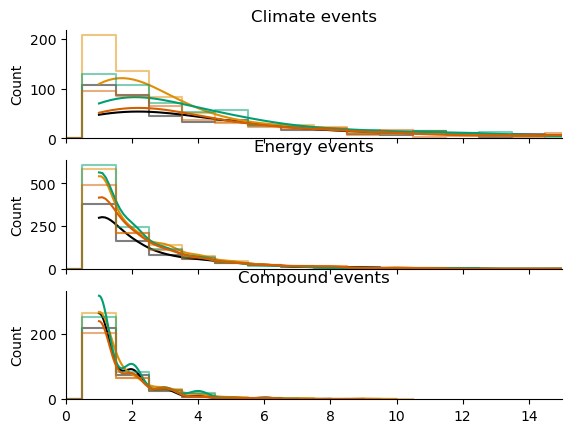

In [88]:
fig, axs = plt.subplots(3, sharex = True)
event_duration_histplot(climate_events, axs[0], palette, legend = False)
axs[0].set_title("Climate events")
event_duration_histplot(energy_events, axs[1], palette, legend = False)
axs[1].set_title("Energy events")
event_duration_histplot(compound_events, axs[2], palette, legend = False)
axs[2].set_title("Compound events")
axs[2].set_xlim(0,15)

AttributeError: 'datetime.date' object has no attribute 'dayofyear'

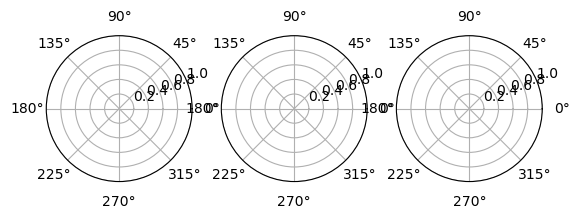

In [89]:
fig, axs = plt.subplots(1, 3, subplot_kw = dict(projection = "polar"))
event_seasonnality_histplot(climate_events, axs[0], palette, legend = False)
axs[0].set_title("Climate events")
event_seasonnality_histplot(energy_events, axs[1], palette, legend = False)
axs[1].set_title("Energy events")
event_seasonnality_histplot(compound_events, axs[2], palette, legend = False)
axs[2].set_title("Compound events")